`Team 16 Dự đoán giá vàng bạc bạch kim bằng thuật toán RNN
`

In [23]:
#Cài đặt thư viện 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})
import numpy as np 
import pandas as pd 
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error
import statsmodels.api as sm
from IPython.display import display, Markdown
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [24]:

df = pd.read_csv('../PlatiumData.csv', parse_dates=True,)
df

,Ngày,Lần cuối,Mở,Cao,Thấp,KL
0,20/5/2018,886.2,886.8,889.0,885.5,NaN
1,21/5/2018,899.5,886.2,902.7,877.8,NaN
2,22/5/2018,908.3,899.5,912.0,896.3,NaN
3,23/5/2018,904.6,908.3,910.4,898.5,NaN
4,24/5/2018,910.4,904.6,914.7,903.5,NaN
...,...,...,...,...,...,...
1553,15/5/2023,1082.8,1057.6,1079.1,1057.5,NaN
1554,16/5/2023,1075.0,1070.5,1078.7,1061.8,NaN
1555,17/5/2023,1090.7,1067.7,1086.1,1067.4,NaN
1556,18/5/2023,1066.3,1079.2,1080.8,1055.0,NaN


In [25]:
#Xem các dữ liệu cơ bản của cảc thuộc tính
df.describe()

,Lần cuối,Mở,Cao,Thấp
count,1558.000000,1558.000000,1558.000000,1558.000000
mean,944.065918,943.859884,955.499743,932.064955
std,116.994315,116.800419,119.007199,115.160228
min,595.200000,596.050000,615.400000,562.000000
25%,852.987500,852.887500,862.150000,844.275000
50%,930.875000,931.225000,941.900000,920.700000
75%,1018.200000,1017.575000,1029.475000,1003.175000
max,1318.750000,1292.800000,1351.200000,1283.150000


In [26]:
#Kiểm tra dữ liệu rỗng
df.isnull().sum()

Ngày          0
Lần cuối      0
Mở            0
Cao           0
Thấp          0
KL          978
dtype: int64

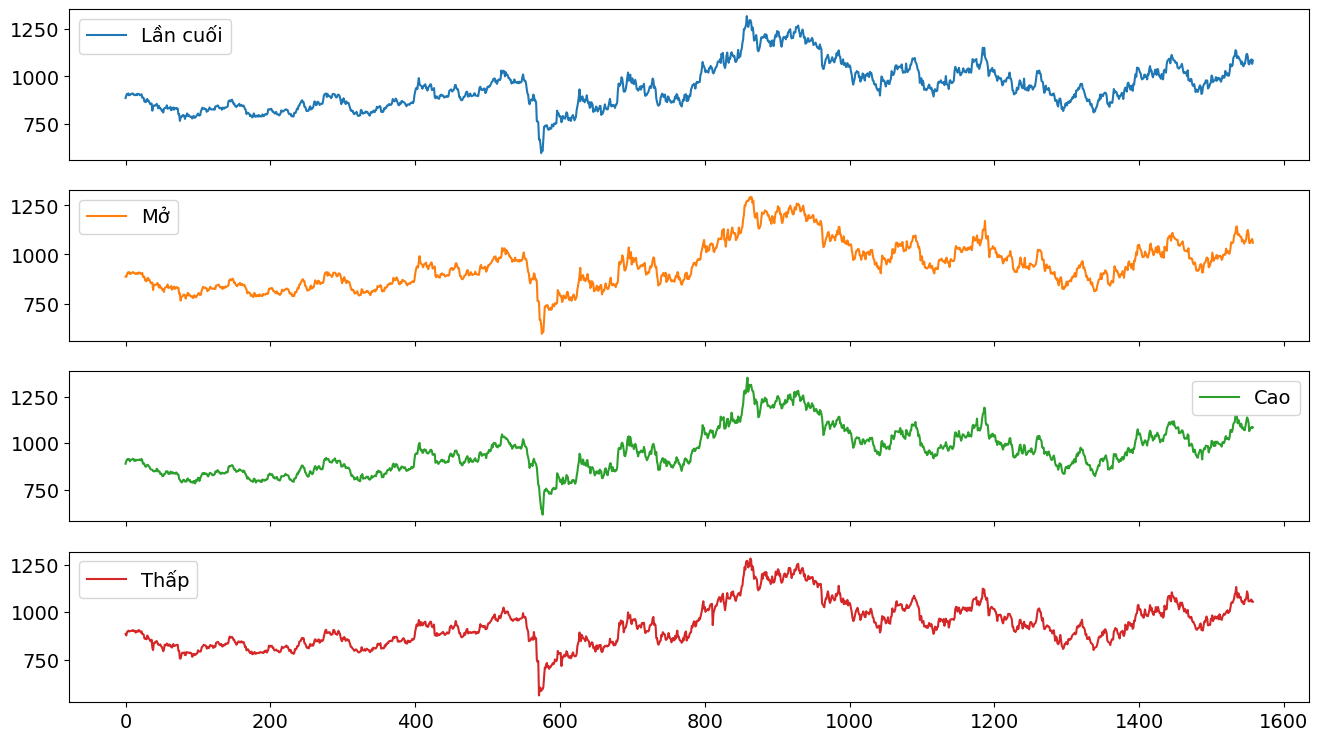

In [27]:
#Xem độ biến thiên của từng thuộc tính.
df.plot(legend=True,subplots=True, figsize = (16, 9))
plt.show()

In [28]:
#Chuyển dataset về cột Close để tiến hành tạo model
df = df[['Lần cuối']]
df

,Lần cuối
0,886.2
1,899.5
2,908.3
3,904.6
4,910.4
...,...
1553,1082.8
1554,1075.0
1555,1090.7
1556,1066.3


In [29]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [30]:
#Chia dữ liệu theo các tỷ lệ 7:2:1
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [31]:
#Tạo hàm create dataset
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX),np.array(dataY)

In [32]:
#Chia thành các tập X,y
time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
print(y_train)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)


[0.34455117 0.34800636 0.34994126 0.35947758 0.34662428 0.32686062
 0.34468938 0.32686062 0.32755166 0.32174694 0.30861723 0.31290167
 0.29576394 0.32299081 0.32865731 0.33003939 0.33363278 0.34855919
 0.32382005 0.32768986 0.32810448 0.32630779 0.33791721 0.31276346
 0.31760072 0.32796628 0.33294175 0.31663327 0.32810448 0.32727524
 0.32962477 0.3228526  0.32520213 0.28277244 0.28470735 0.23495266
 0.25678944 0.26660217 0.26687858 0.27738235 0.27655311 0.27323613
 0.24932624 0.26991915 0.27295971 0.28995923 0.27171585 0.27917905
 0.27074839 0.26618755 0.2653583  0.26591113 0.2523668  0.26300878
 0.27295971 0.25803331 0.25830972 0.26411444 0.2726833  0.28277244
 0.28885357 0.27558565 0.27406537 0.27669131 0.30405639 0.31649506
 0.33142146 0.32271439 0.32368185 0.32672241 0.32147053 0.32119411
 0.30129224 0.30861723 0.30875544 0.32022666 0.33294175 0.32147053
 0.3209177  0.31801534 0.31787713 0.31801534 0.32354364 0.31690968
 0.34095778 0.34081957 0.34289268 0.34772994 0.34551862 0.3315

In [33]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(20,activation='relu',return_sequences=True,input_shape=(time_step, 1)))
model.add(SimpleRNN(20,activation='relu',return_sequences=True))
model.add(SimpleRNN(20,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [34]:

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32,verbose=1)


Epoch 1/100
28/28 [==============================] - 3s 26ms/step - loss: 0.3544 - val_loss: 0.2084
Epoch 2/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0868 - val_loss: 0.0266
Epoch 3/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0081 - val_loss: 0.0029
Epoch 4/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 5/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 6/100
28/28 [==============================] - 0s 12ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 8/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/100
28/28 [==============================] - 0s 13ms/step - loss: 9.8253e-04 - val_loss: 0.0011
Epoch 10/100
28/28 [==============================] - 0s 13ms/step - loss: 8.3779e-04 - val_loss

In [35]:

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)


4/4 [==============================] - 0s 4ms/step


In [36]:

# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
y_test=scaler.inverse_transform(y_test.reshape(-1,1))
y_val=scaler.inverse_transform(y_val.reshape(-1,1))


In [37]:
# Đánh giá 
def deviation(test, pred):
  rmse= np.sqrt(mean_squared_error(test,pred))
  print(f"RMSE: {rmse:.2f}")
  mape= mean_absolute_percentage_error(test,pred)
  print(f"MAPE: {mape*100:.2f}%")
  mae = mean_absolute_error(test, pred)
  print(f"MAE: {mae:.2f}")

In [38]:
#Hàm visualize
def visualize(label ,pred, model_name):
  plt.figure(figsize=(12,8))
  plt.plot(label, label = 'Ground truth')
  plt.plot(pred, label='Predict')
  plt.title(model_name)
  plt.xlabel('Date')
  plt.ylabel('Closing Price')
  plt.legend()
  plt.show()

In [39]:

y_test2=scaler.inverse_transform(y_test.reshape(-1,1))
y_val2=scaler.inverse_transform(y_val.reshape(-1,1))

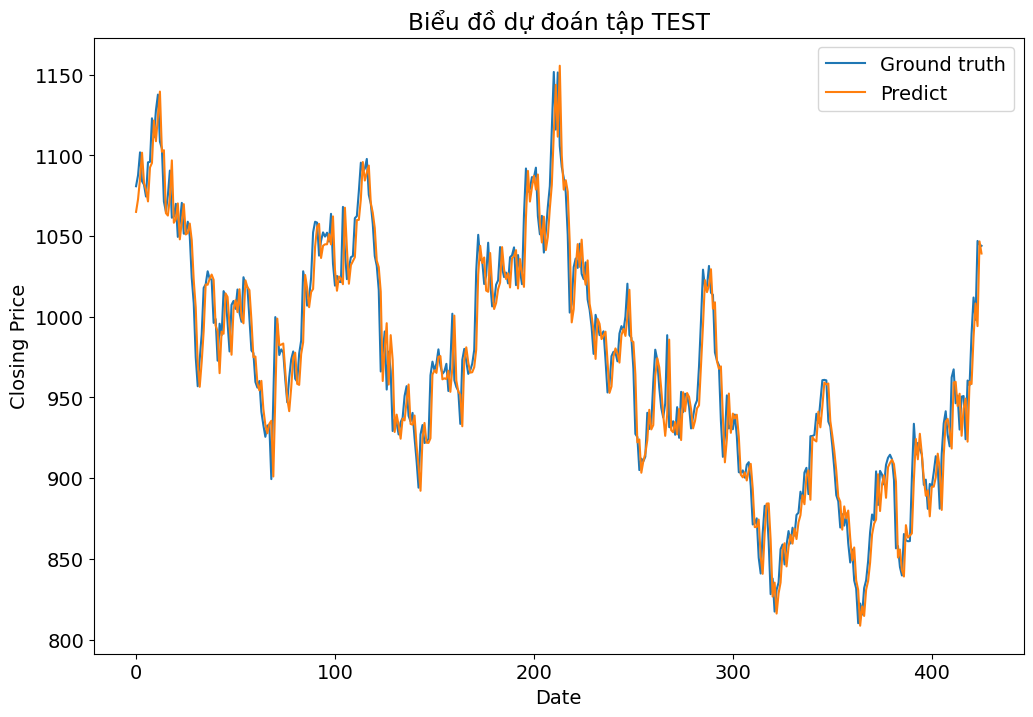

Đánh Giá tập TEST
RMSE: 18.09
MAPE: 1.44%
MAE: 13.97


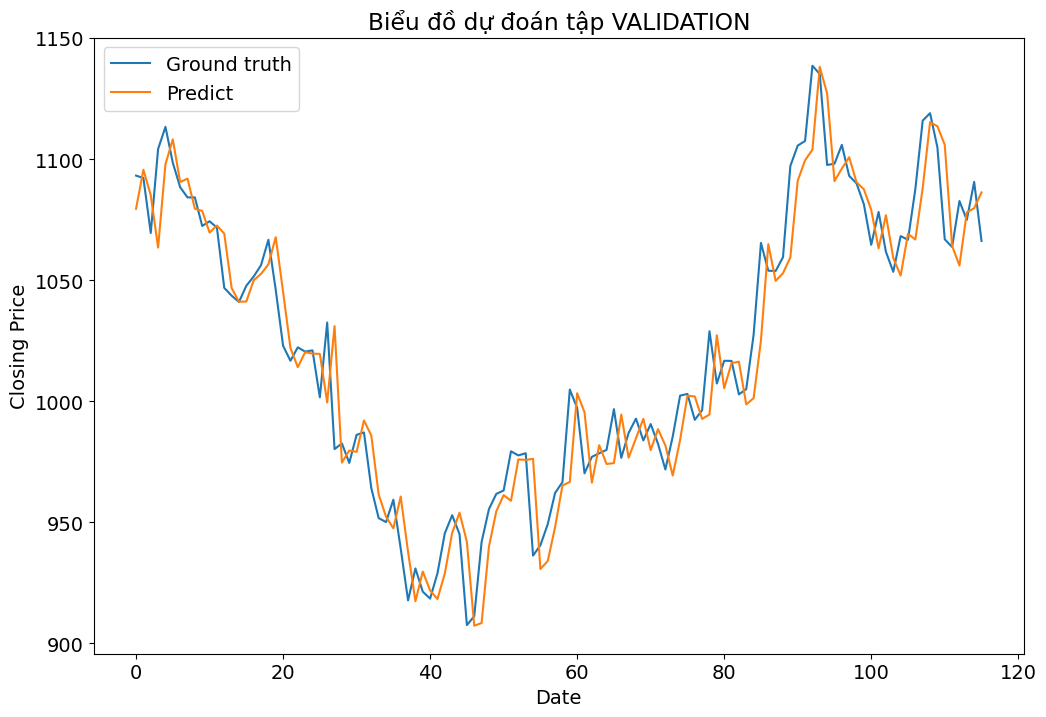

Đánh Giá tập VALIDATION
RMSE: 17.07
MAPE: 1.28%
MAE: 13.03


In [40]:
# visualize(y_train,y_pred_train,'Biểu đồ dự đoán tập TRAIN')
visualize(y_test,y_pred,'Biểu đồ dự đoán tập TEST')
print('Đánh Giá tập TEST')
deviation(y_test, y_pred)

visualize(y_val,y_pred_val,'Biểu đồ dự đoán tập VALIDATION')
print('Đánh Giá tập VALIDATION')
deviation(y_val, y_pred_val)

In [41]:

val_len=len(val_data)
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=val_len-60
i=0
while(i<30):
        
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.6730153]
98
1 day input [0.58268261 0.59035312 0.58793449 0.58862553 0.56181328 0.60451938
 0.53223689 0.53548476 0.52435906 0.54039113 0.5417732  0.50998549
 0.49284776 0.49056734 0.50335153 0.47543363 0.44585723 0.46410062
 0.4508327  0.44689379 0.46133647 0.4842098  0.49450625 0.48372607
 0.43176007 0.43680464 0.47916523 0.49796144 0.50666851 0.50860341
 0.53099302 0.52864349 0.52988736 0.47142561 0.47736853 0.48939258
 0.50722134 0.51337157 0.56623592 0.55573215 0.51841614 0.52781425
 0.52988736 0.53182227 0.55504112 0.52726142 0.54149679 0.54965103
 0.53721236 0.54654136 0.53527745 0.52062746 0.53942367 0.56278073
 0.56374819 0.54895999 0.55448829 0.59954392 0.56969111 0.58268261
 0.5826135  0.56347177 0.56651234 0.5974708  0.64998963 0.63409578
 0.63395757 0.64183539 0.6939396  0.70554903 0.70817497 0.75115749
 0.74638933 0.69449243 0.69518347 0.70596365 0.6882731  0.68398867
 0.67203372 0.64888397 0.66768019 0.64487596 0.63347384 0.65385944
 0.65178633 0.68067169 0.7197844  0

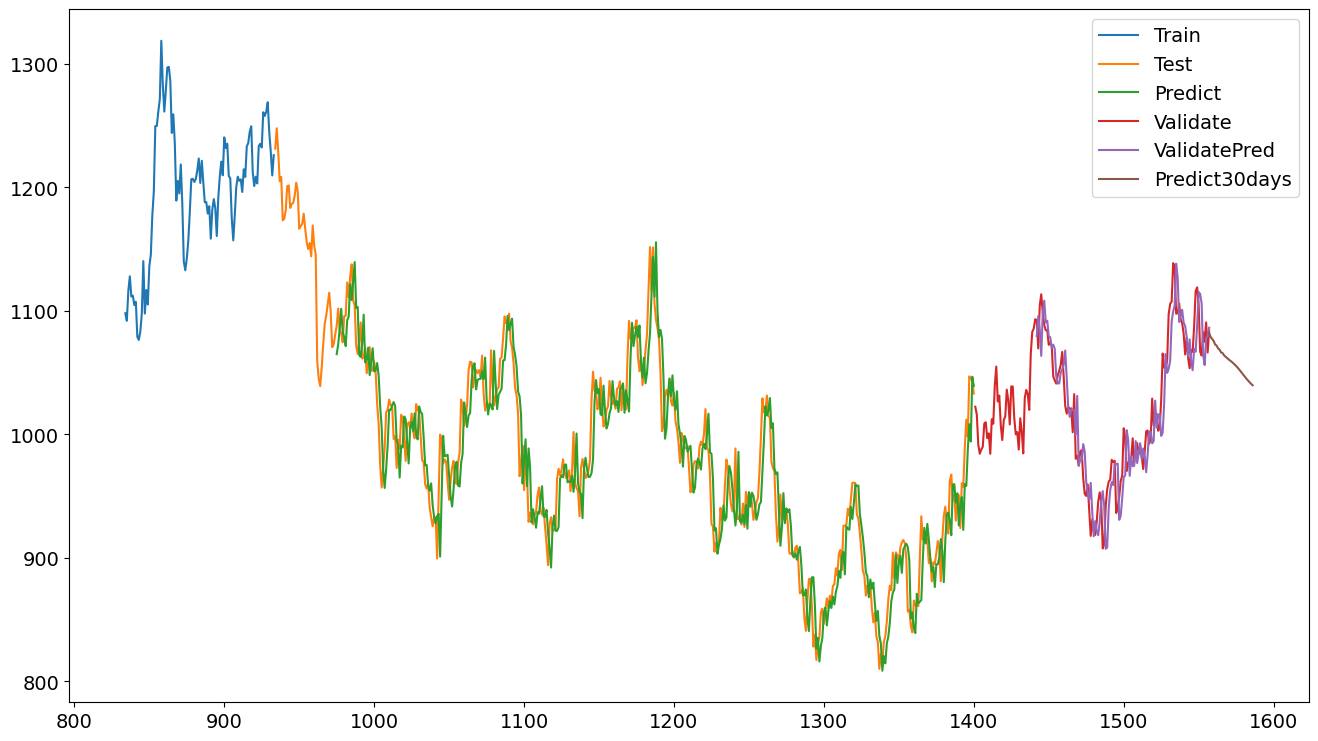

In [42]:
# Vẽ hình
plt.figure(figsize=(16,9))

train_data_index = pd.RangeIndex(start=train_size-100, stop=train_size, step=1)
plt.plot(train_data_index,scaler.inverse_transform(train_data[train_size-100:]))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+ 41, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

val_data_index = pd.RangeIndex(start=train_size + test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size + test_size+ 41, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)


prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()